# Automated Liver Segmentation Using MONAI

In [2]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import torch
from torch.utils.data import DataLoader
import glob


import sys
sys.path.append('../')
#import utils

import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent
from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance

monai.config.print_config()

MONAI version: 0.3.0rc3
Python version: 3.8.3 (default, May 19 2020, 18:47:26)  [GCC 7.3.0]
Numpy version: 1.19.5
Pytorch version: 1.5.1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.0
scikit-image version: 0.17.2
Pillow version: 7.2.0
Tensorboard version: 2.2.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.6.0a0+35d732a
ITK version: 5.1.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Verify System Setup
Check torch and CUDA on the system.

In [3]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [4]:
## Load Public LiverHccSeg Dataset

LiverHccSeg_path = 'LiverHccSeg/nifti_and_segms/*/*/*art_pv.nii.gz'

LiverHccSeg_paths = glob.glob(LiverHccSeg_path)
LiverHccSeg_accs = []
for i in LiverHccSeg_paths:
    LiverHccSeg_accs.append(i.split('/')[-3])
    
df_LiverHccSeg_imgs = pd.DataFrame({'ACCESSION_ID': LiverHccSeg_accs, 'IMAGE' : LiverHccSeg_paths})



accs = list()
for i in LiverHccSeg_paths:
    accs.append(i.split('/')[-3])
    
    
df_LiverHccSeg = pd.DataFrame({'ACCESSION_ID':accs, 'IMAGE': LiverHccSeg_paths})
df_LiverHccSeg


,ACCESSION_ID,IMAGE
0,TCGA-G3-A25T,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
1,TCGA-G3-AAV2,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
2,TCGA-G3-A3CJ,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
3,TCGA-DD-A4NH,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
4,TCGA-BC-4073,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
5,TCGA-DD-A4NB,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
6,TCGA-G3-A7M7,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
7,TCGA-G3-AAV1,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
8,TCGA-G3-AAV3,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...
9,TCGA-G3-AAV7,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...


In [5]:
inference_data_dict = df_LiverHccSeg.to_dict('records')

## Setup Input Transformations

In [6]:
SPACING = (2.0,2.0,2.0)

test_transforms = Compose([
    LoadNiftid(keys=['IMAGE']),
    AddChanneld(keys=['IMAGE']),
    Orientationd(keys=['IMAGE'], axcodes='RAS'),
    Spacingd(keys=['IMAGE'], pixdim=SPACING, mode=('bilinear'), padding_mode=('reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE'])
])



## Check Input Data

torch.Size([1, 1, 170, 107, 100])
image shape: torch.Size([170, 107, 100])
image mean: 0.2101699411869049


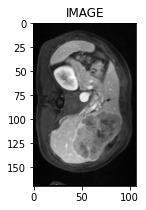

In [7]:
check_ds = monai.data.Dataset(data=inference_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image= (check_data['IMAGE'][i][0])
    print('image shape: {}'.format(image.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 1, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')


## Create a Monai Data Loader

In [8]:
inference_ds = monai.data.Dataset(data=inference_data_dict, transform=test_transforms)
inference_loader = DataLoader(inference_ds, batch_size=1, num_workers=4)

## Create Segmentation Model (U-net)

In [9]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH)
        
        self.loss_function = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
        
        self.val_metric = DiceMetric(include_background=True, to_onehot_y=True, sigmoid=True, reduction="mean")

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                monai.networks.nets.UNet(
                    dimensions=3, 
                    in_channels=1, 
                    out_channels=2, 
                    channels=(16, 32, 64, 128),
                    strides=(2, 2, 2), 
                    num_res_units=2, 
                    norm=Norm.BATCH), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Loss/Train', avg_loss, self.current_epoch)
        return {'loss': avg_loss}
    
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)
        value = self.val_metric(y_pred=outputs, y=labels)

        return {"val_loss": loss, "val_dice": value}


    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Loss/Val', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Dice/Val', avg_dice, self.current_epoch)

        # Handle the first time
        if self.best_val_dice is None:
            self.best_val_dice = avg_dice
            self.best_val_epoch = self.current_epoch
        if avg_loss < self.best_val_dice:
            self.best_val_dice = avg_dice
            self.best_val_epoch = self.current_epoch
        return {"val_loss": avg_loss, "val_dice": avg_dice}


    def test_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        value = self.val_metric(y_pred=outputs, y=labels)
        return {"test_dice": value}

    
    def test_epoch_end(self, outputs):
        test_dice, num_items = 0, 0
        for output in outputs:
            test_dice += output["test_dice"].sum().item()
            num_items += len(output["test_dice"])
        mean_test_dice = torch.tensor(test_dice / num_items)
        tensorboard_logs = {
            "test_dice": mean_test_dice,
        }
        print(
            f"current epoch: {self.current_epoch} current test mean dice: {mean_test_dice:.4f}"
        )
        return {"log": tensorboard_logs}

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [10]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation().to(device)
summary(model, (1,64,64,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 32, 32, 16]             448
            Conv3d-2       [-1, 16, 32, 32, 16]             448
       BatchNorm3d-3       [-1, 16, 32, 32, 16]              32
             PReLU-4       [-1, 16, 32, 32, 16]               1
            Conv3d-5       [-1, 16, 32, 32, 16]           6,928
       BatchNorm3d-6       [-1, 16, 32, 32, 16]              32
             PReLU-7       [-1, 16, 32, 32, 16]               1
      ResidualUnit-8       [-1, 16, 32, 32, 16]               0
            Conv3d-9        [-1, 32, 16, 16, 8]          13,856
           Conv3d-10        [-1, 32, 16, 16, 8]          13,856
      BatchNorm3d-11        [-1, 32, 16, 16, 8]              64
            PReLU-12        [-1, 32, 16, 16, 8]               1
           Conv3d-13        [-1, 32, 16, 16, 8]          27,680
      BatchNorm3d-14        [-1, 32, 16

## Perform Inference Public Dataset


In [11]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm


def inference(model, data_loader, output_path=None, roi_size=(224,224,128), max_eval=None, plot_results=False, filename_prefix_key=None):

    df = pd.DataFrame()

    model.eval()
    device = torch.device("cuda:0")
    model.to(device)

    input_paths = list()
    output_results = list()
    
    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
            
            # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            
            input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
        
            
            input_paths.append(input_file_name)
            
            sw_batch_size = 4
            
            inference_data = test_data['IMAGE'].to(device)
            test_outputs = sliding_window_inference(inference_data, roi_size, sw_batch_size, model)
            argmax = torch.argmax(test_outputs, dim=1, keepdim=True)
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)

   
            if plot_results:
                slice_num = test_data['IMAGE'].shape[-1]//2

                plt.figure('check', (18, 6))
                plt.subplot(1, 2, 1)
                plt.title('image ' + str(i))
                plt.imshow(test_data['IMAGE'][0, 0, :, :, slice_num], cmap='gray')
                plt.subplot(1, 2, 2)
                plt.title('output %d' % (i))
                plt.imshow(largest.detach().cpu()[0, 0, :, :, slice_num])
                plt.show()

              
            if output_path is not None:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                # Write data out
                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                acc_id = input_file_name.split('/')[-3]
                print(acc_id)
                
                output_file_name = os.path.split(input_file_name)[1]
                output_file_name = input_file_name.split('/')[-2]
                output_file_name = acc_id
                print(output_file_name)
                
                
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path = os.path.join(OUTPUT_PATH,'{}_T1_PV_automated_liver_segm.nii.gz'.format(output_file_name))
                
                print(output_path)
                output_results.append(output_path)

                write_nifti(largest.cpu()[0, 0,...].numpy(), output_path,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

                
                output_path = os.path.join(OUTPUT_PATH,'{}_PV.nii.gz'.format(output_file_name))
                print(output_path)
                write_nifti(inference_data.cpu()[0, 0,...].numpy(), output_path,
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )
                 

    
    df['PV'] = input_paths
    if output_path is not None:
        df['LIVER_SEGM'] = output_results
            
    return df

In [12]:
# Update the `MODEL_ROOT_PATH` variable with the path to the directory where the trained model files are stored 
# on your local machine. This path is crucial for the code to correctly locate and load the model.
# Ensure that the path is accurate and points to the root directory containing the model files.
# Example format: MODEL_ROOT_PATH = "/path/to/your/model/directory"


MODEL_ROOT_PATH = r'../resources/'





In [13]:
# Load the trained model 
checkpoint = torch.load(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt'))

model = MRILiverSegmentation()
model.load_state_dict(checkpoint['state_dict'])



<All keys matched successfully>

0it [00:00, ?it/s]

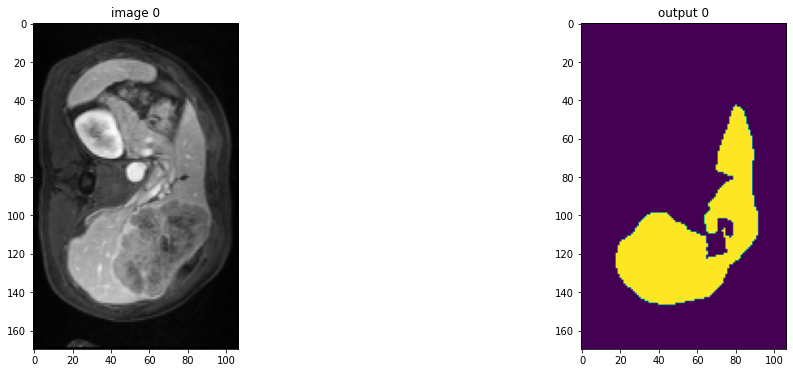

TCGA-G3-A25T
TCGA-G3-A25T
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A25T_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A25T_PV.nii.gz


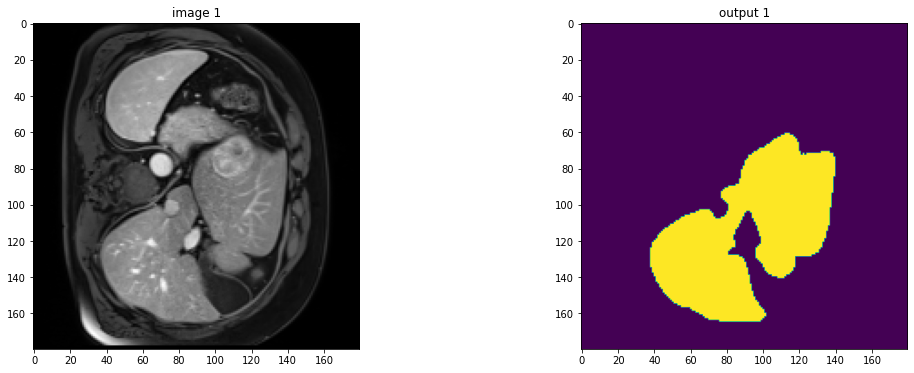

TCGA-G3-AAV2
TCGA-G3-AAV2
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV2_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV2_PV.nii.gz


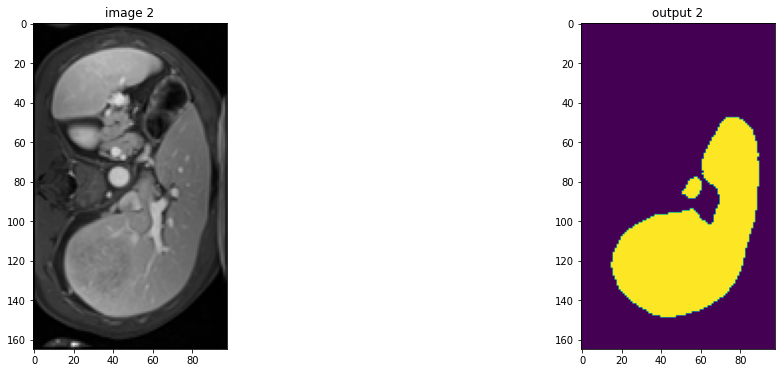

TCGA-G3-A3CJ
TCGA-G3-A3CJ
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A3CJ_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A3CJ_PV.nii.gz


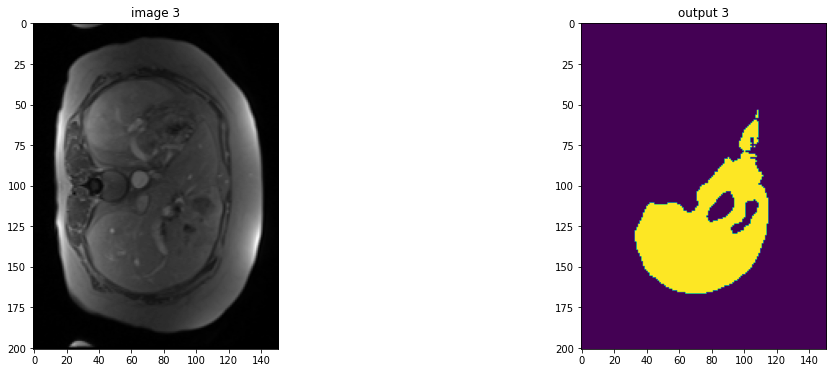

TCGA-DD-A4NH
TCGA-DD-A4NH
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NH_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NH_PV.nii.gz


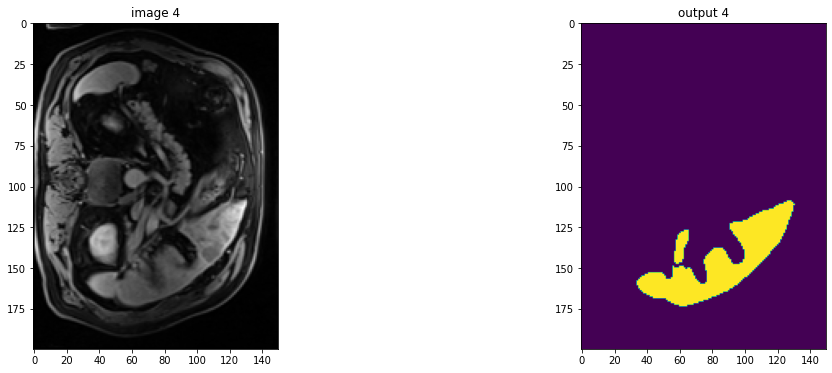

TCGA-BC-4073
TCGA-BC-4073
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-4073_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-4073_PV.nii.gz


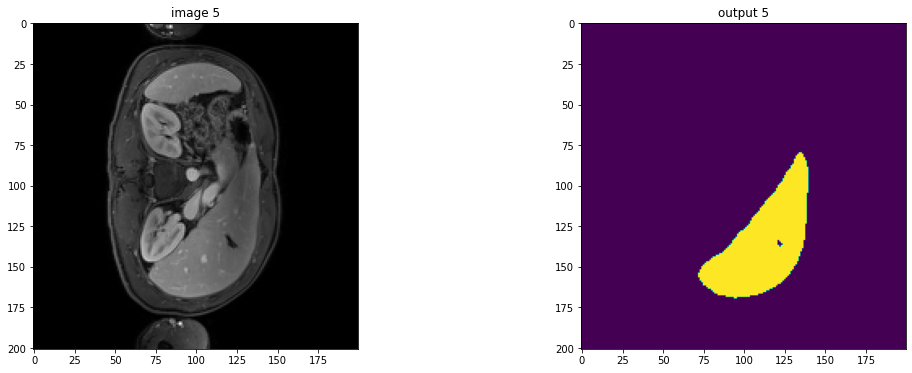

TCGA-DD-A4NB
TCGA-DD-A4NB
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NB_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NB_PV.nii.gz


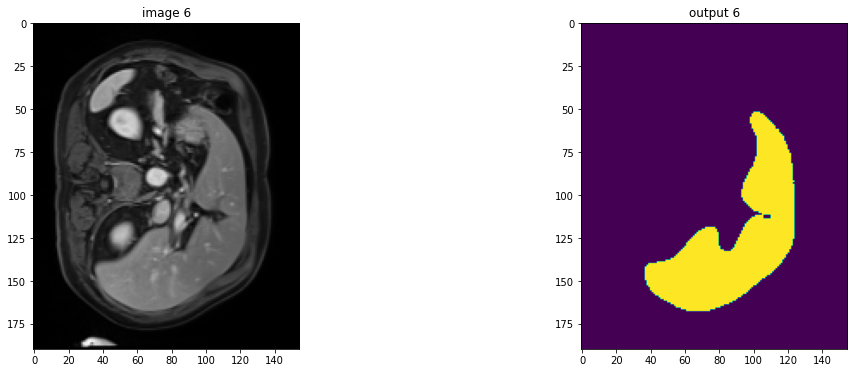

TCGA-G3-A7M7
TCGA-G3-A7M7
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A7M7_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-A7M7_PV.nii.gz


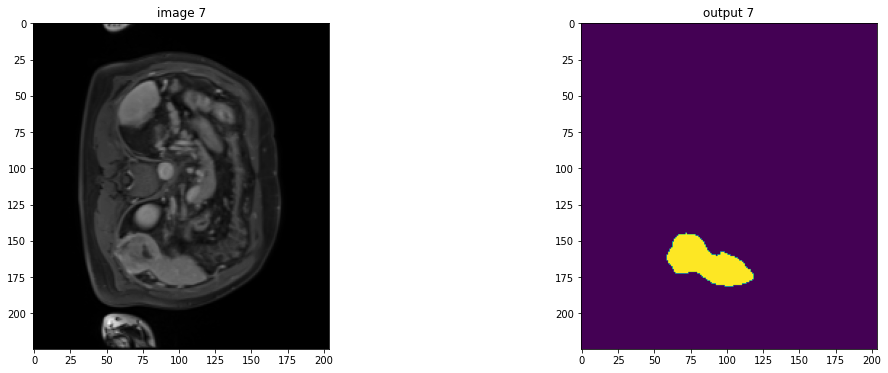

TCGA-G3-AAV1
TCGA-G3-AAV1
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV1_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV1_PV.nii.gz


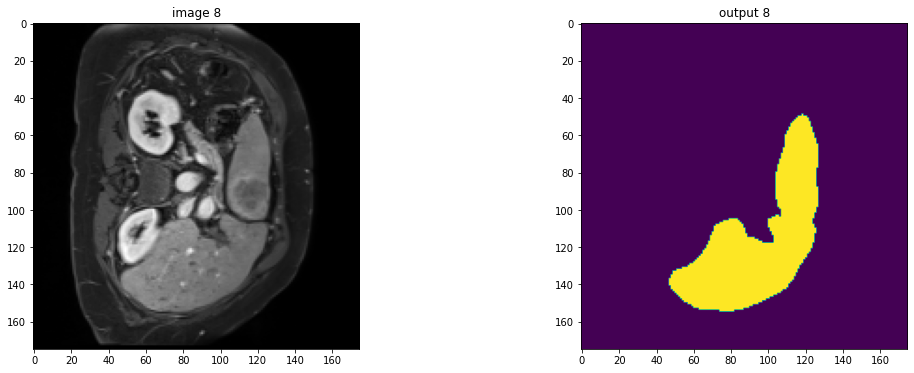

TCGA-G3-AAV3
TCGA-G3-AAV3
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV3_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV3_PV.nii.gz


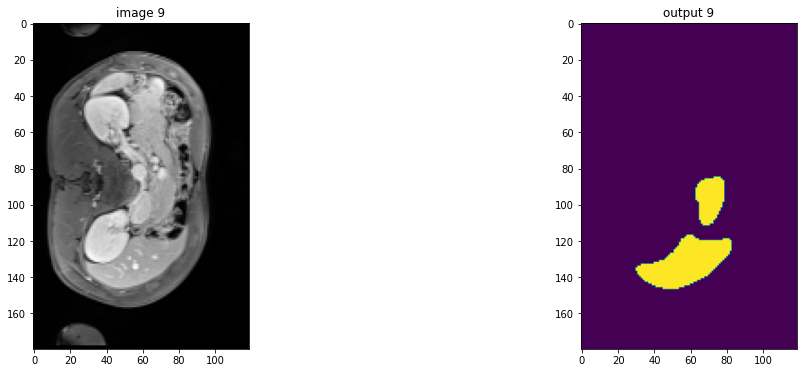

TCGA-G3-AAV7
TCGA-G3-AAV7
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV7_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-G3-AAV7_PV.nii.gz


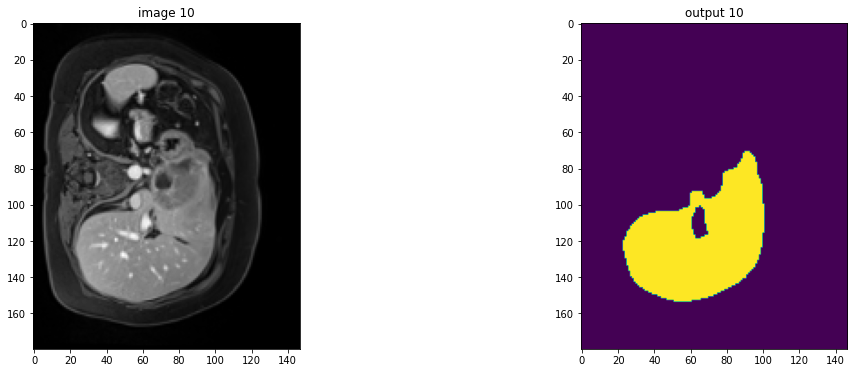

TCGA-BC-A3KG
TCGA-BC-A3KG
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A3KG_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A3KG_PV.nii.gz


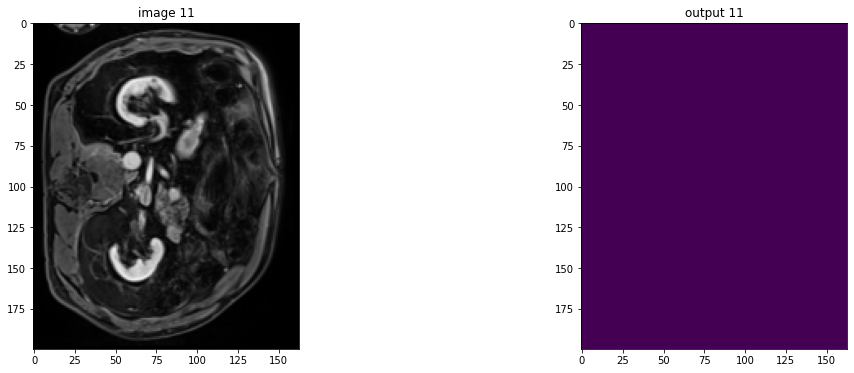

TCGA-BC-A69I
TCGA-BC-A69I
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A69I_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A69I_PV.nii.gz


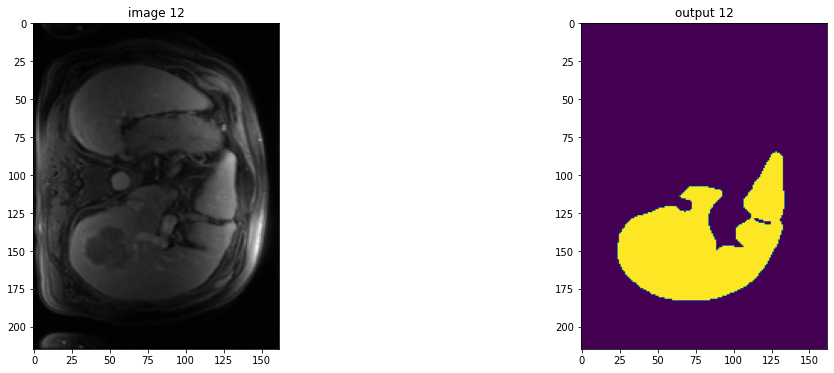

TCGA-BC-A5W4
TCGA-BC-A5W4
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A5W4_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A5W4_PV.nii.gz


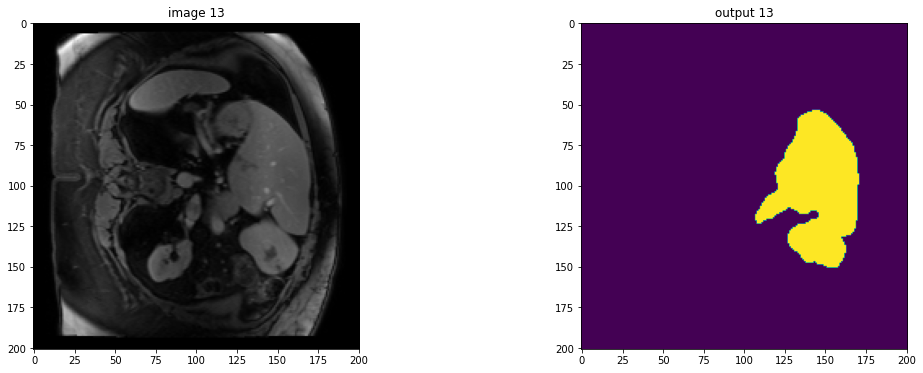

TCGA-BC-A216
TCGA-BC-A216
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A216_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A216_PV.nii.gz


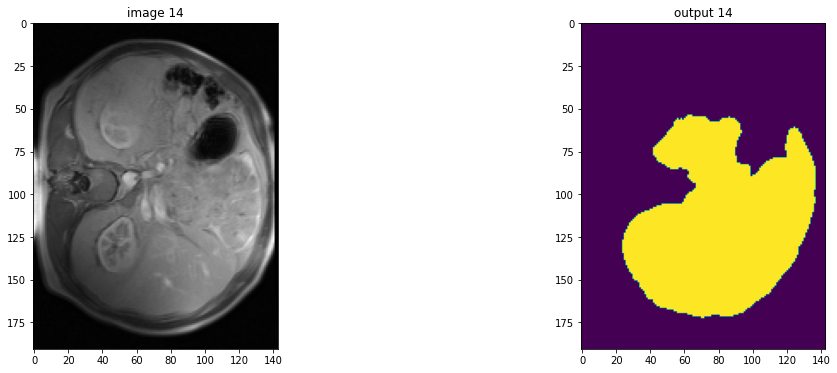

TCGA-BC-A10Y
TCGA-BC-A10Y
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A10Y_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-BC-A10Y_PV.nii.gz


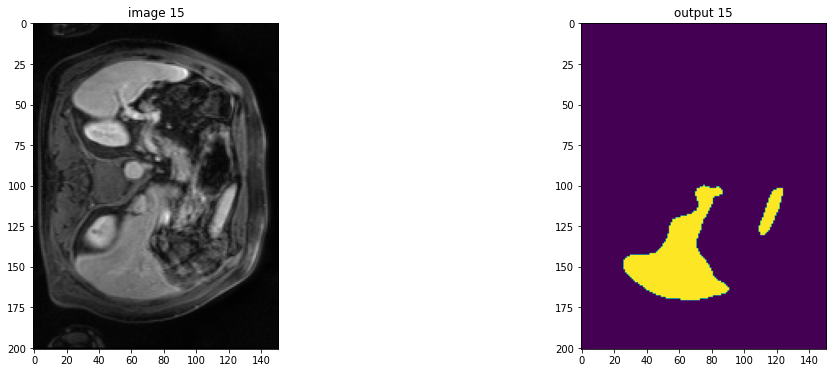

TCGA-DD-A4NF
TCGA-DD-A4NF
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NF_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NF_PV.nii.gz


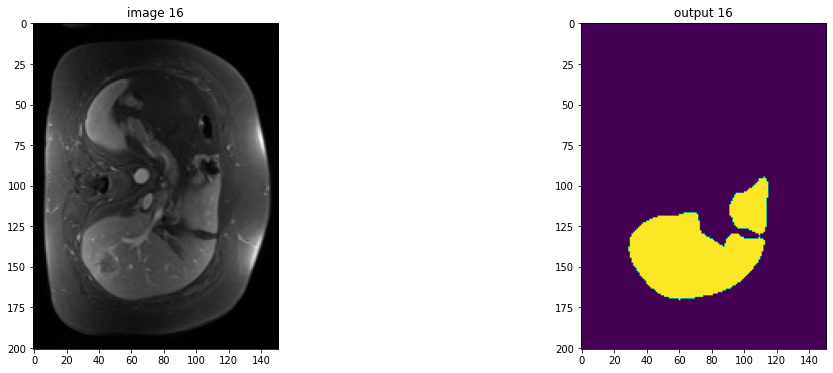

TCGA-DD-A4NJ
TCGA-DD-A4NJ
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NJ_T1_PV_automated_liver_segm.nii.gz
/tensor5/data1/mgross/Liver/studies/mr_liver_segm/mr_segm_ex2/Volumetry-Net/Volumetry-Net/output/inference/TCGA-DD-A4NJ_PV.nii.gz


,PV,LIVER_SEGM
count,17,17
unique,17,17
top,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...
freq,1,1


In [14]:
# Update the `OUTPUT_PATH` variable with the path to the directory where want to store
# the generated liver segmentation masks on your local machine. 



OUTPUT_PATH = r'inference'

df_inference = inference(model=model, data_loader=inference_loader,
                        plot_results = True, output_path=OUTPUT_PATH,filename_prefix_key='ACCESSION_ID')
df_inference.describe()

In [15]:
for idx, row in  df_inference.iterrows():
        df_inference.loc[idx, 'ACCESSION_ID'] = row['PV'].split('/')[-3]

In [16]:
df_inference

,PV,LIVER_SEGM,ACCESSION_ID
0,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-A25T
1,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-AAV2
2,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-A3CJ
3,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-DD-A4NH
4,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-BC-4073
5,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-DD-A4NB
6,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-A7M7
7,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-AAV1
8,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-AAV3
9,/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...,/tensor5/data1/mgross/Liver/studies/mr_liver_s...,TCGA-G3-AAV7


In [17]:
df_inference.to_csv('Volumetry-NET-LiverHccSeg.csv', index=False)